# Deep Q-Network implementation



In [1]:
ABS_PATH = 'checkpoints/dqn/'

In [2]:
import os
if not os.path.exists(ABS_PATH):
    os.mkdir(ABS_PATH)

In [3]:
import gym
import numpy as np
import pandas as pd
import tqdm
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from buffers.replay_buffer import ReplayBuffer
from buffers.frame_buffer import FrameBuffer
from preprocessings.atari_preprocessing import InvadersPreprocess

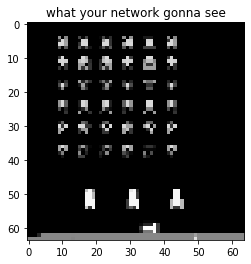

In [4]:
import gym
# spawn game instance for tests
env = gym.make("SpaceInvaders-v0")  # create raw env
env = InvadersPreprocess(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

plt.title("what your network gonna see")
plt.imshow(obs.reshape((64,64)), interpolation='none', cmap='gray')

### Frame buffer

In [5]:
def make_env():
    env = gym.make("SpaceInvaders-v0")
    env = InvadersPreprocess(env)
    env = FrameBuffer(env, n_frames=3, dim_order='tensorflow')
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

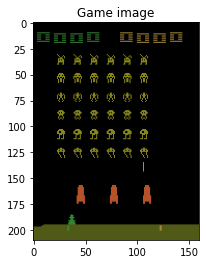

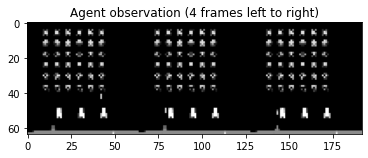

In [6]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]), cmap='gray')

### Building a network


### Majour settings

In [7]:
path_agent = 'checkpoints/dqn/agent_model_weights_step:0_date:2020-10-02.h5'
initial_epsilon = 1
eta = 2.5e-4
gamma=0.99
load = True
train = False

In [8]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [9]:
class DQNAgent:
    def __init__(self, state_dim, n_actions, epsilon=0.9, gamma=0.9,
                eta=1e-4, huber_delta=1.0):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.eta = eta
        self.model, self.sess = self.make_model()
        self.initiate_placeholders()
        self.train_step, self.loss = self.make_graph(huber_delta)
        self.sess.run(tf.global_variables_initializer())
        self.chosen_path = None
        
    def make_model(self):
        tf.reset_default_graph()
        sess = tf.InteractiveSession()
        tf.keras.backend.set_session(sess)
        x = Input(shape=self.state_dim)
        model = Conv2D(filters=16, kernel_size=(3,3), padding='valid', strides=(2,2), activation='relu')(x)
        model = Conv2D(filters=32, kernel_size=(3,3), padding='valid', strides=(2,2),activation='relu')(model)
        model = Conv2D(filters=64, kernel_size=(3,3), padding='valid', strides=(2,2),activation='relu')(model)
        model = Flatten()(model)
        model = Dense(256, activation='relu')(model)
        model = Dense(n_actions)(model)
        model = Model(inputs=x, outputs=model)
        return model, sess
    
    def initiate_placeholders(self):
        self.states_ph = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.actions_ph = tf.keras.backend.placeholder(dtype='int32', shape=[None])
        self.rewards_ph = tf.keras.backend.placeholder(dtype='float32', shape=[None])
        self.next_states_ph = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.is_done_ph = tf.keras.backend.placeholder(dtype='bool', shape=[None])
    
    def argmax(self,q_table):
        max_value = np.max(q_table)
        idxs = np.where(q_table==max_value)[0]
        if idxs.shape[0]>1:
            return np.random.choice(idxs)
        else:
            return np.argmax(q_table)
        
    def get_action(self, state):
        q_values = self.model.predict(state[None])[0]
    
        if np.random.rand()<self.epsilon:
              action = np.random.choice(n_actions)
        else:
              action = self.argmax(q_values)

        return action
    
    def make_graph(self, delta=1.0):
        predicted_qvalues = self.model(self.states_ph)
        predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(self.actions_ph, self.n_actions), 
                                                      axis=1)
        predicted_next_qvalues = self.model(self.next_states_ph)
        next_state_values = tf.reduce_max(predicted_next_qvalues,axis=1)
        target_qvalues_for_actions = self.rewards_ph+self.gamma*next_state_values
        target_qvalues_for_actions = tf.where(self.is_done_ph, self.rewards_ph, target_qvalues_for_actions)
        error = predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)
        squared_error = (error ** 2)*0.5
        abs_error = tf.math.abs(error)-(0.5*(delta**2))
        flag = tf.cast(tf.math.abs(error)<=delta,'float32')
        loss = squared_error*flag+(1.0-flag)*abs_error*delta
        loss = tf.reduce_mean(loss)
        return tf.train.AdamOptimizer(self.eta).minimize(loss), loss
    
    def update(self,obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch):
        _, loss_t = self.sess.run([self.train_step,self.loss],{
            self.states_ph : obs_batch, 
            self.actions_ph : act_batch, 
            self.rewards_ph : reward_batch, 
            self.next_states_ph : next_obs_batch, 
            self.is_done_ph : is_done_batch})
        return loss_t
    
    def save_weights(self,path):
        self.model.save_weights(path)
    
    def load_weights(self,path=None):
        if not path:
            files = os.listdir(ABS_PATH)
            assert files, "Can't load weights, as there is no saved weight in {0}".format('checkpoints/dqn/')
            path = sorted(files, key=lambda x: re.findall(r'step:\d+',x)[0].split(':')[1])[-1]
            path = os.path.join(ABS_PATH,path)   
            self.chosen_path = path
        self.model.load_weights(path)
        print('Loaded weights')

In [10]:
agent = DQNAgent(state_dim, n_actions, epsilon=initial_epsilon,eta=eta,
                gamma=gamma)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now let's try out our agent to see if it raises any errors.

In [11]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=5000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            if greedy:
                last_epsilon = agent.epsilon
                agent.epsilon = 0 
            action = agent.get_action(s)
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    if greedy:
        agent.epsilon = last_epsilon
    return np.mean(rewards)

In [12]:
evaluate(env, agent, n_games=1)

50.0

In [13]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    s = env.framebuffer
    rewards = 0
    last_info = None
    for i in range(n_steps):
      a = agent.get_action(s)
      next_s, r, done, info = env.step(a)
      if (last_info is not None and last_info['ale.lives'] > info['ale.lives'] ):
        done = True
      exp_replay.add(s,a,r,next_s,done)
      s = next_s
      last_info = info
      rewards += r
      if done:
        s = env.reset()
    return rewards

In [14]:
if load:
    path_agent = path_agent if path_agent else None
    agent.load_weights(path_agent)
    

Loaded weights


### Main loop


In [15]:
epochs = 3
buffer_size = 30000
annealing = 0.998
batch_size = 64

In [16]:
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

def moving_average(x, span=100, **kw):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values

mean_rw_history = []
td_loss_history = []

In [17]:
if train:
    date_stamp = datetime.datetime.strftime(datetime.datetime.now(), format='%Y-%m-%d')
    exp_replay = ReplayBuffer(buffer_size)
    play_and_record(agent, env, exp_replay, n_steps=10000)

    continue_train = False
    if agent.chosen_path:
        continue_train = True
        step = int(re.findall(r'_step:\d+',agent.chosen_path)[0].split(':')[1])

    for i in trange(epochs*50000):
        # play
        play_and_record(agent, env, exp_replay, 10)

        # train
        loss_t = agent.update(*exp_replay.sample(batch_size))
        td_loss_history.append(loss_t)

        # adjust agent parameters
        if i % 500 == 0:
            agent.epsilon = max(agent.epsilon * annealing, 0.01)
            mean_rw_history.append(evaluate(make_env(), agent, n_games=3))

        if i%(10*50000)==0:
            if continue_train:
                step+=i
            else:
                step = i
            agent.model.save_weights(os.path.join(ABS_PATH,f'agent_model_weights_step:{step}_date:{date_stamp}.h5'))

        if i % 100 == 0:
            clear_output(True)
            print("buffer size = %i, epsilon = %.5f, epoch = %i" % (len(exp_replay), agent.epsilon,i//50000))

            plt.subplot(1, 2, 1)
            plt.title("mean reward per game")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(loss_t)
            plt.figure(figsize=[12, 4])
            plt.subplot(1, 2, 2)
            plt.title("TD loss history (moving average)")
            plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
            plt.grid()
            plt.show()
        agent.model.save_weights(os.path.join(ABS_PATH,f'agent_model_weights_step:{step}_date:{date_stamp}.h5'))


Text(0, 0.5, 'reward')

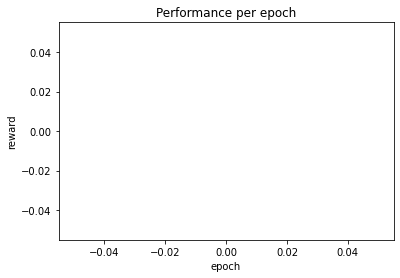

In [18]:
result = [np.mean(mean_rw_history[i:i+100]) for i in range(0,len(mean_rw_history),100)]
plt.plot(result,'o-')
plt.title('Performance per epoch')
plt.xlabel('epoch')
plt.ylabel('reward')

# Visualization of playing

In [19]:
agent.epsilon = 0

In [20]:
from IPython.core import display

In [21]:

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Sum of rewards : 200.0


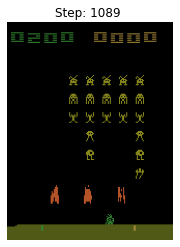

In [23]:
env = make_env()
steps = 2000
s = env.reset()
rewards = 0
last_info = None
for t in range(steps):
    show_state(env,t)
    env.render()
    a = agent.get_action(s)
    next_s, r, done, info = env.step(a)
    if (last_info is not None and last_info['ale.lives'] > info['ale.lives'] ):
        done = True
    rewards+=r
    s = next_s
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
display.clear_output(wait=True)
print("Sum of rewards : {}".format(rewards))